In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Defining paths
data_path = '/content/drive/MyDrive/lung_cancer_datset/lung_cancer.zip'
extract_path = '/content/lung_cancer'

# Create directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the dataset
with ZipFile(data_path, 'r') as zip:
    zip.extractall(extract_path)
    print('The dataset has been extracted.')

path = os.path.join(extract_path, 'lung_colon_image_set/lung_image_sets')
classes = os.listdir(path)
print("Classes found:", classes)

The dataset has been extracted.
Classes found: ['lung_n', 'lung_aca', 'lung_scc']


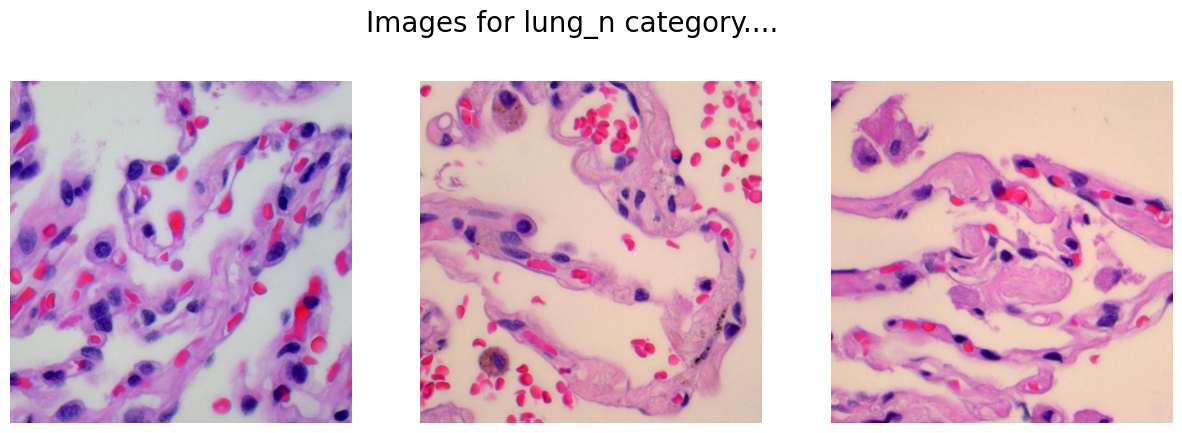

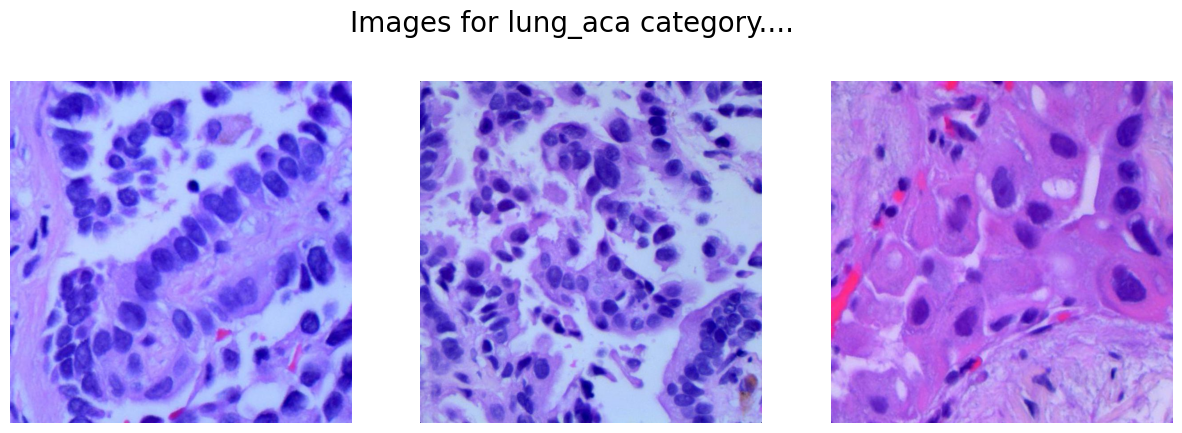

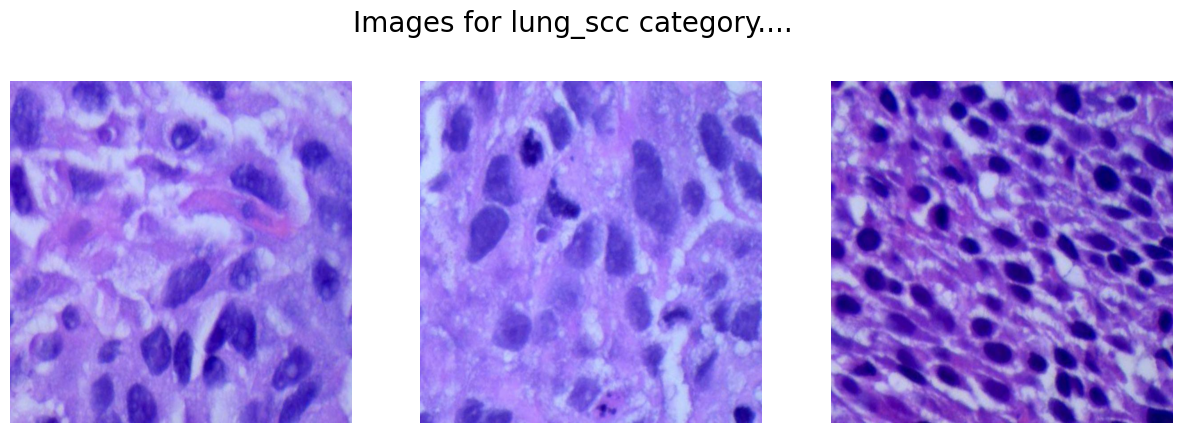

In [4]:
# Displaying sample images
for cat in classes:
    image_dir = os.path.join(path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category....', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(path, cat, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
#Defining parameters
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [6]:
#Load and preprocess images
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(os.path.join(path, cat, '*.jpeg'))

    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
#Splitting the data
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                 test_size=SPLIT,
                                                 random_state=2022)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (12000, 256, 256, 3)
Validation set shape: (3000, 256, 256, 3)


In [9]:
#Defining the model
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu',
                 input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [10]:
#Displaying model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

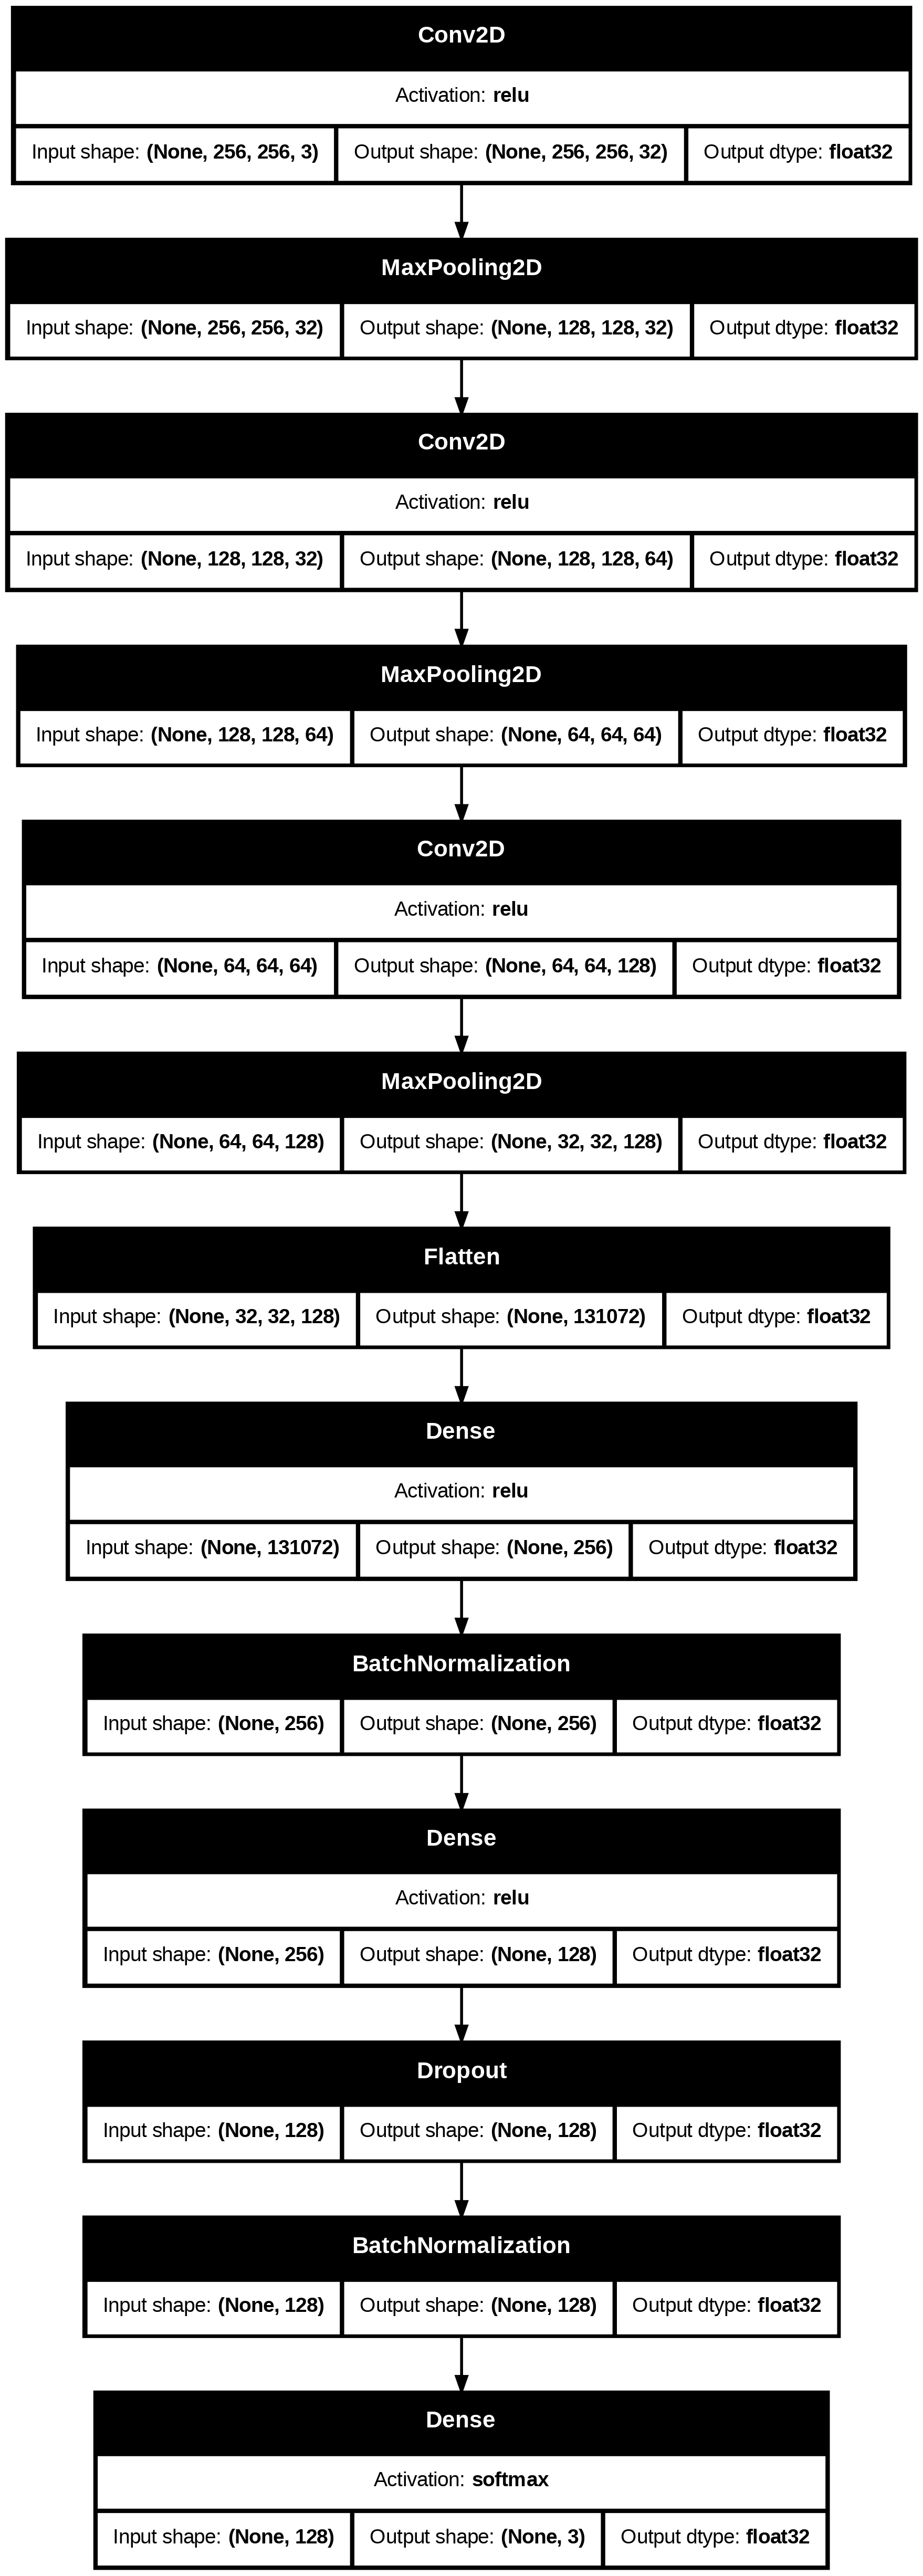

In [11]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [12]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [14]:
#Training the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[es, lr, myCallback()]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 241ms/step - accuracy: 0.7786 - loss: 0.5170 - val_accuracy: 0.5767 - val_loss: 1.7451 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.8865 - loss: 0.2698 - val_accuracy: 0.7107 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.9277 - loss: 0.1826 - val_accuracy: 0.6893 - val_loss: 1.1807 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9432 - loss: 0.1428
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.9432 - loss: 0.1428 - val_accuracy: 0.6737 - val_loss: 1.4897 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - accuracy: 0.9708 - loss: 0.0884 - val_accuracy: 0.7520 - val_loss: 1.5330 - learning_rate: 5.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0

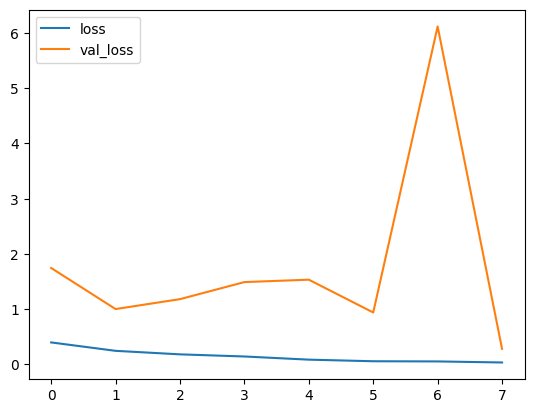

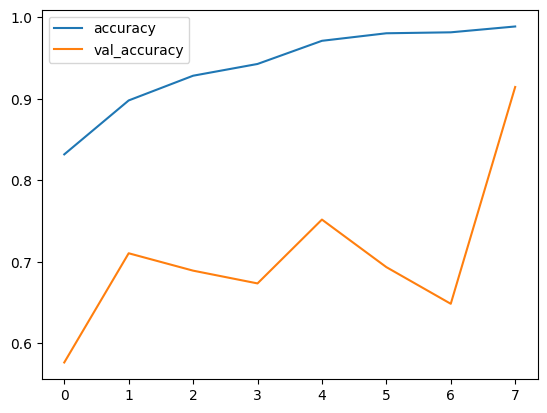

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
# Evaluate the model
Y_pred = model.predict(X_val)
Y_val_classes = np.argmax(Y_val, axis=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Display confusion matrix and classification report
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(Y_val_classes, Y_pred_classes))
print("\nClassification Report:")
print(metrics.classification_report(Y_val_classes, Y_pred_classes, target_names=classes))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step

Confusion Matrix:
[[855 131   1]
 [  0 908  69]
 [  0  55 981]]

Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      0.87      0.93       987
    lung_aca       0.83      0.93      0.88       977
    lung_scc       0.93      0.95      0.94      1036

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.92      3000
weighted avg       0.92      0.91      0.92      3000

